## Tim - Trying out LSTM Neutral Network on Data

Very basic implementation seems to work very well!

In [2]:
import numpy as np

import matplotlib

import matplotlib.pyplot as plt

import pandas as pd

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

df = pd.read_csv('LSI_data.csv')

# 

In [3]:
num_values = len(df.index)

data = df.to_numpy()

t = data[:,1] - data[0,1] # t -

day_seconds = 24 * 60 * 60

week_seconds = day_seconds * 7

year_seconds = week_seconds * 52

start_time = 176 * day_seconds  + (16 * 60 * 60 + 57 * 60)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


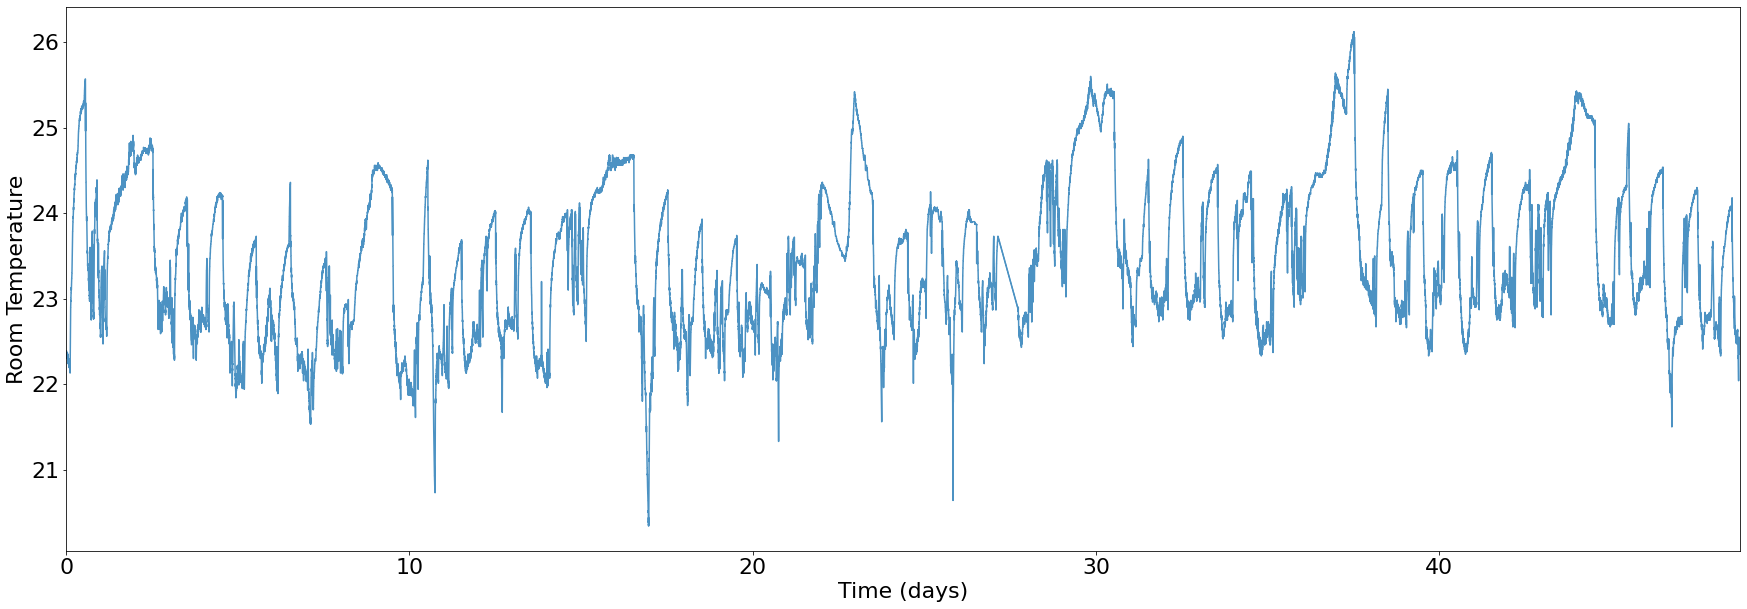

In [4]:
fig, ax = plt.subplots(figsize=(30,10))
ax.plot(t / (60 * 60 * 24),data[:,3],'-', alpha = 0.8)
ax.set_xlim(0.0, max(t / (60 * 60 * 24)) + 0.01)
ax.set_xlabel("Time (days)")
ax.set_ylabel("Room Temperature")
plt.show()

In [5]:
n = len(t)
dt = t[1] - t[0]
f = data[:,3]

fhat = np.fft.fft(f,n)
PSD = np.real(fhat * np.conj(fhat) / n)
freq = (1 / (dt * n)) * np.arange(n)

L = np.arange(1, np.floor(n/2), dtype = 'int')

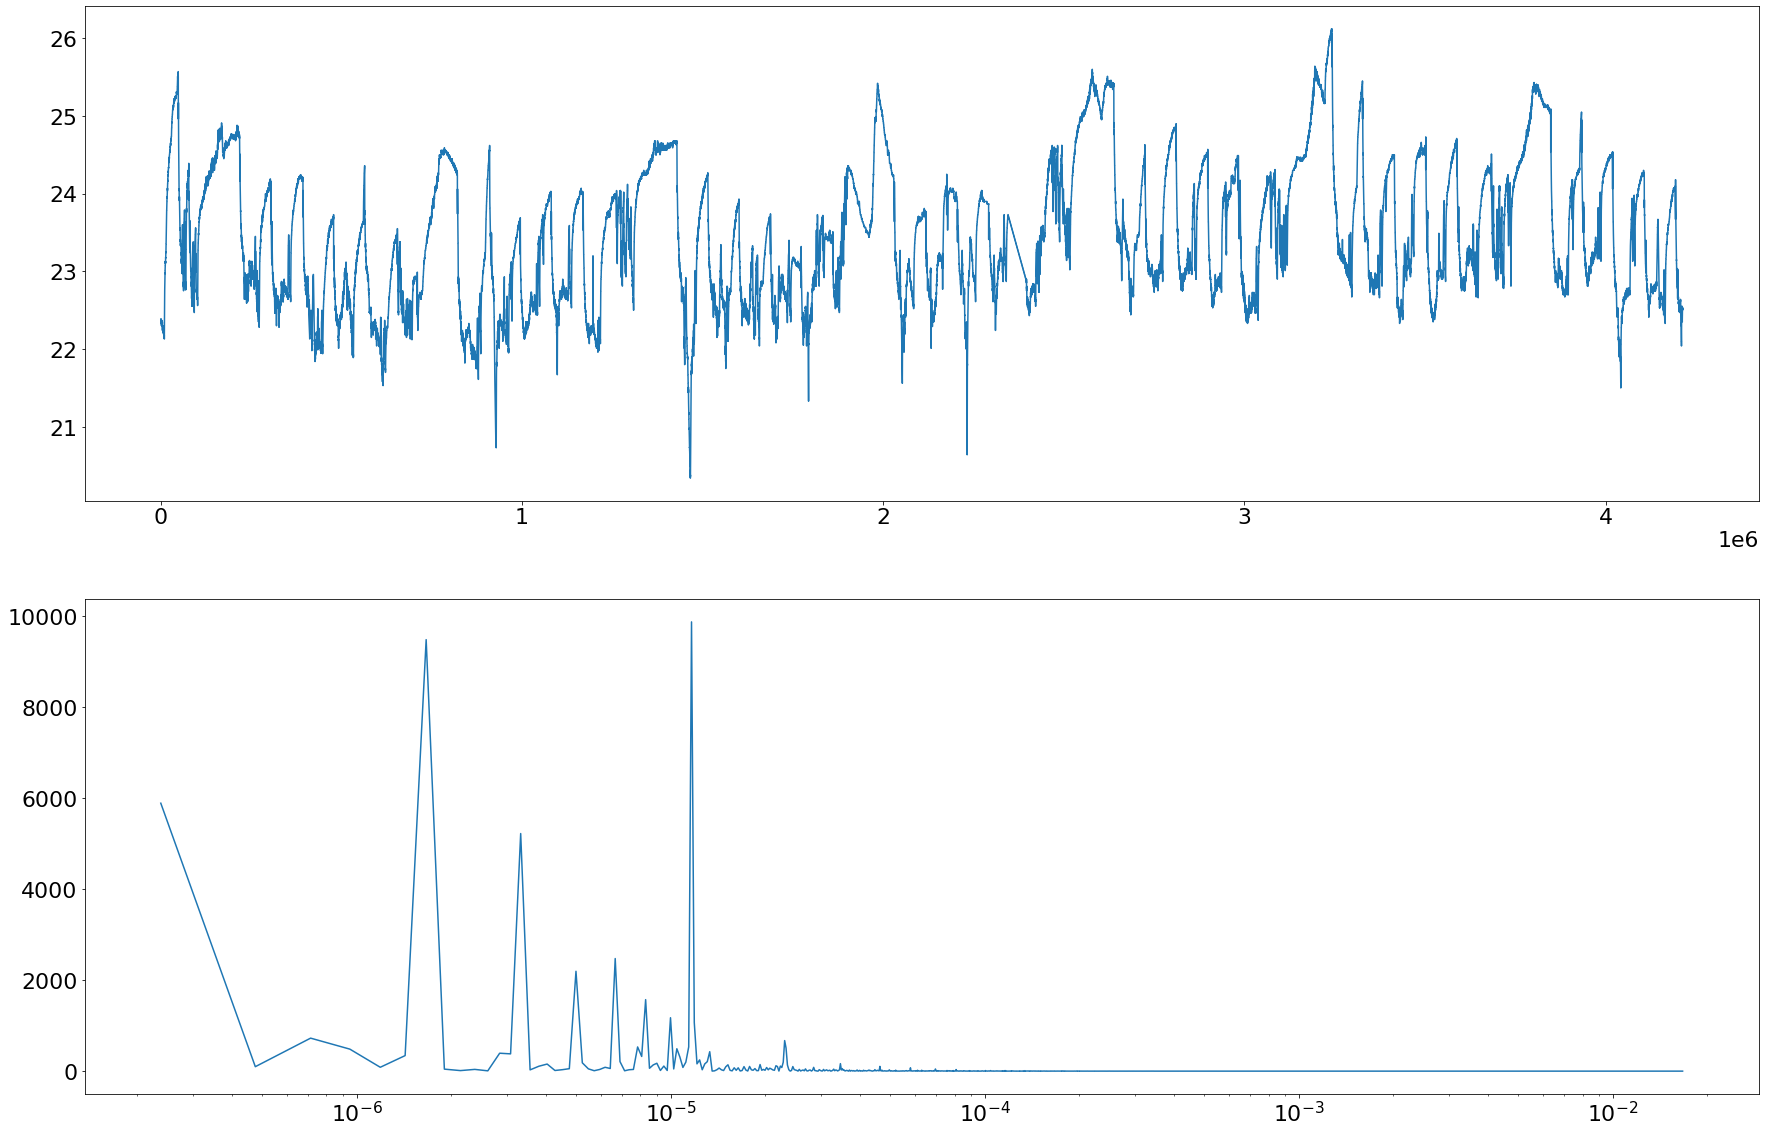

In [6]:
fig, axs = plt.subplots(2,1, figsize=(30,20))

plt.sca(axs[0])
plt.plot(t, f, label = 'noisy')
plt.sca(axs[1])
plt.plot(freq[L],PSD[L])
axs[1].set_xscale('log')    

## Filtering out noise and Inverse fft

In [7]:
ids = PSD > 20.
PSDclean = PSD * ids
fhat_clean = fhat * ids
ffilt = np.fft.ifft(fhat_clean)
fnew = np.real(ffilt)

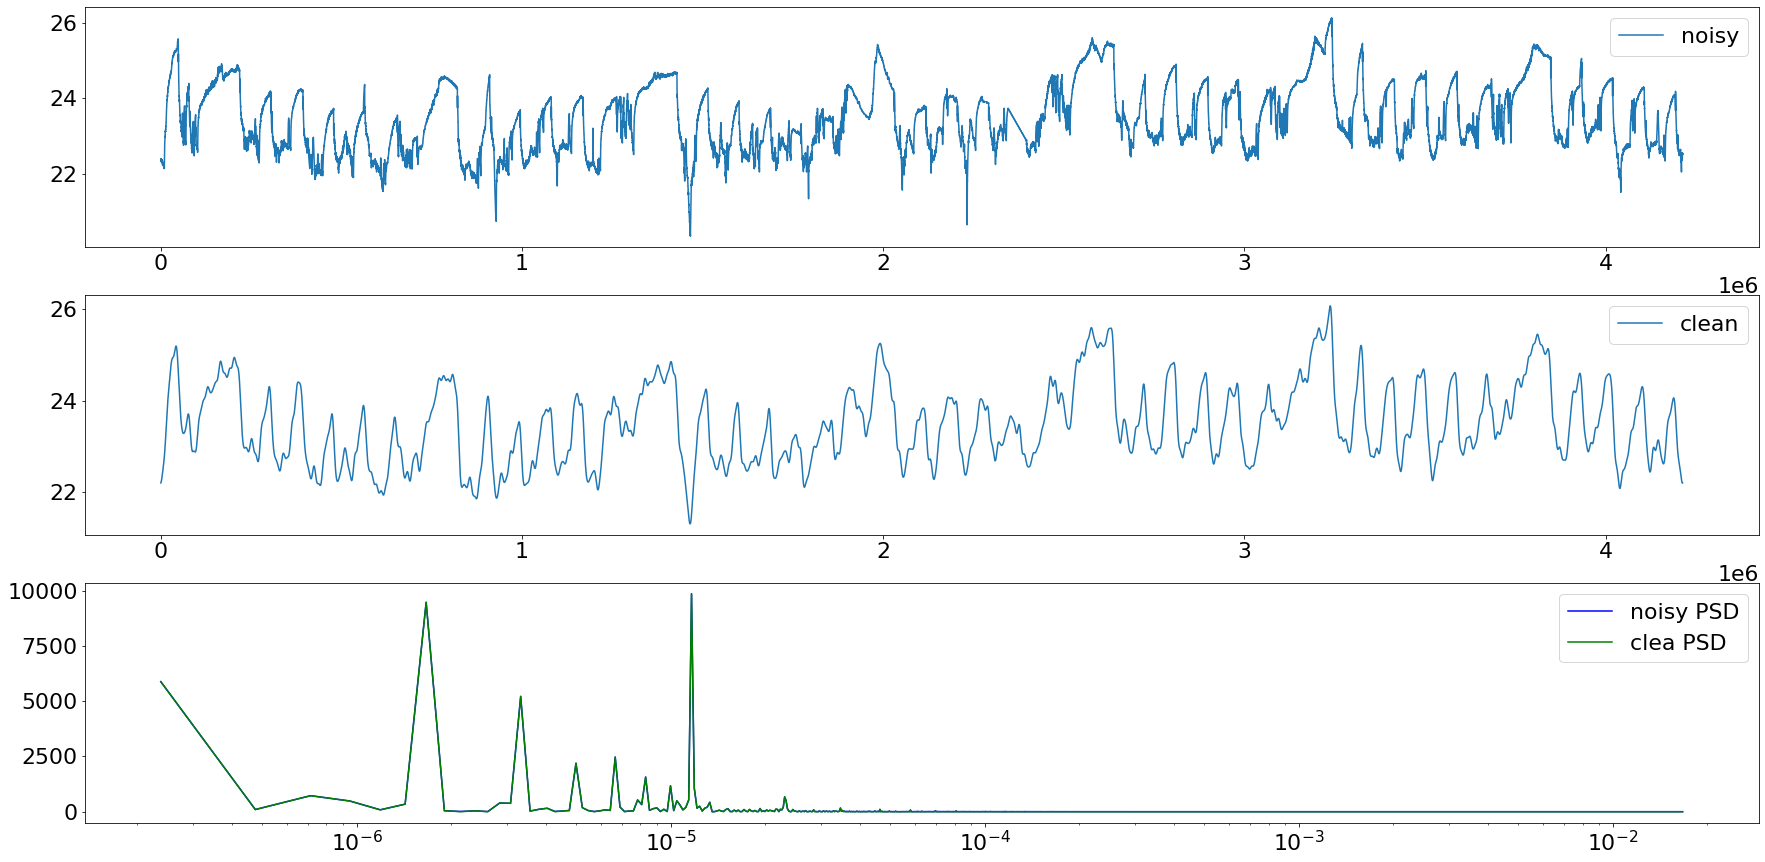

In [8]:
fig, axs = plt.subplots(3,1, figsize=(30,15))

plt.sca(axs[0])
plt.plot(t, f, label = 'noisy')
plt.legend()

plt.sca(axs[1])
plt.plot(t, fnew, label = 'clean')
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L],PSD[L], '-b', label ='noisy PSD')
plt.plot(freq[L],PSDclean[L], '-g', label ='clea PSD')
axs[2].set_xscale('log')
plt.legend()

In [9]:
import gpytorch

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [10]:
N = len(fnew) - 1

X_train_o = np.zeros((N, 4))
y_train_o = np.zeros((N, 1))



for i, val in enumerate(fnew):

    time = start_time + t[i]
    
    if(i < N):
        X_train_o[i][0] = val
        X_train_o[i][1] = (time % day_seconds) / day_seconds
        X_train_o[i][2] = (time % week_seconds) / week_seconds
        X_train_o[i][3] = (time % year_seconds) / year_seconds

    if(i > 0):
        y_train_o[i-1] = val 


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X_train_o)
y_mm = mm.fit_transform(y_train_o) 


In [12]:
# Partition for Training

train_samples = int(0.9 * len(y_train_o))
test_samples = int(len(y_train_o) - train_samples)

#first 200 for training

X_train = X_ss[:train_samples, :]
X_test = X_ss[train_samples:, :]

y_train = y_mm[:train_samples, :]
y_test = y_mm[train_samples:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (126392, 4) (126392, 1)
Testing Shape (14044, 4) (14044, 1)


In [13]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [14]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([126392, 1, 4]) torch.Size([126392, 1])
Testing Shape torch.Size([14044, 1, 4]) torch.Size([14044, 1])


In [15]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [16]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 4 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.37771
Epoch: 100, loss: 0.02672
Epoch: 200, loss: 0.01165
Epoch: 300, loss: 0.00295
Epoch: 400, loss: 0.00151
Epoch: 500, loss: 0.00088
Epoch: 600, loss: 0.00052
Epoch: 700, loss: 0.00033
Epoch: 800, loss: 0.00021
Epoch: 900, loss: 0.00015


In [17]:
df_X_ss = ss.transform(X_train_o) #old transformers
df_y_mm = mm.transform(y_train_o) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


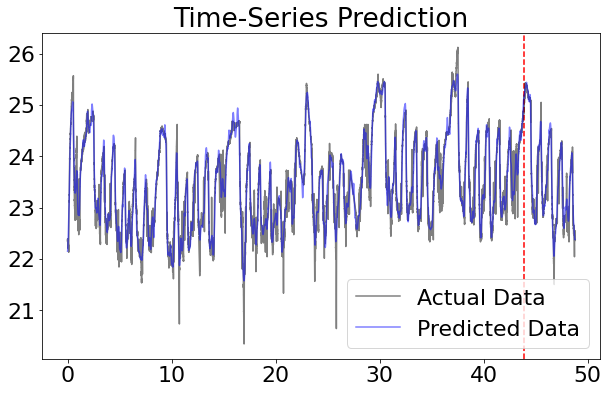

In [18]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=t[train_samples]/day_seconds, c='r', linestyle='--')
plt.plot(t[train_samples-1000:-1] / day_seconds, f[train_samples-1000:-1], label='Actual Data', c='k', alpha = 0.5) #actual plot
plt.plot(t[train_samples-1000:-1] / day_seconds, data_predict[train_samples-1000:], label='Predicted Data', c='b', alpha = 0.5) #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 